In [62]:
import numpy as np
import pandas as pd

In [63]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
anchor_table=pd.read_excel(r'C:\Users\yakoyak\Desktop\NearestNeighbors\Anchor_eNBs.xlsx')
print('4G Anchor Sites:')
print(anchor_table)
DU_table=pd.read_excel(r'C:\Users\yakoyak\Desktop\NearestNeighbors\5G_gNBs_DUs.xlsx')
print('\n5G DU Nodes:')
print(DU_table)

4G Anchor Sites:
                     SITE    eNB   Latitude  Longitude
0         BROWN_ODAS01_RI  60509  41.827089 -71.402182
1         BROWN_ODAS02_RI  60510  41.831961 -71.403545
2         BROWN_ODAS03_RI  60511  41.834909 -71.400052
3        BROWN_UNIVERSITY  60170  41.828808 -71.395911
4     CENTRAL_FALLS_RI_HD  60097  41.886827 -71.390310
5    EAST_PROVIDENCE_5_RI  60326  41.808419 -71.345314
6    EAST_PROVIDENCE_6_RI  60291  41.817181 -71.372867
7   NORTH_PROVIDENCE_3_RI  60161  41.856949 -71.442282
8      PROVIDENCE_2_RI_HD  60005  41.816037 -71.411917
9         PROVIDENCE_4_RI  60074  41.840253 -71.452801
10        PROVIDENCE_5_RI  60060  41.804297 -71.403525
11     PROVIDENCE_CNTR_RI  60068  41.827085 -71.409368
12  PROVIDENCE_COLLEGE_RI  60132  41.844476 -71.434378
13  PROVIDENCE_DT_RELO_RI  60152  41.828727 -71.419867
14     PROVIDENCE_HUB1_RI  60475  41.833003 -71.478428
15     PROVIDENCE_HUB3_RI  60479  41.843392 -71.440484
16    PROVIDENCE_RI_ODAS7  60506  41.836213 -71.

In [65]:
from scipy import spatial
anchors_cartesian = []
for index, row in anchor_table.iterrows():
    coordinates = [row['Latitude'], row['Longitude']]
    cartesian_coord = cartesian(*coordinates)
    anchors_cartesian.append(cartesian_coord)
    
anchor_table_tree = spatial.KDTree(anchors_cartesian)

### Get the k nearest 4G Anchor eNBs to a selected 5G DU


In [86]:
# Get the k nearest 4G Anchor eNBs to selected 5G DU
DU=DU_table[['Latitude', 'Longitude']].values[0]
k=5
distances, indices = anchor_table_tree.query(cartesian(DU[0], DU[1]), k=k)
k_nearest_anchors = anchor_table.iloc[indices.ravel()].copy()
k_nearest_anchors['Distance'] = distances.ravel()
k_nearest_anchors

,SITE,eNB,Latitude,Longitude,Distance
0,BROWN_ODAS01_RI,60509,41.827089,-71.402182,276.056721
1,BROWN_ODAS02_RI,60510,41.831961,-71.403545,336.395517
11,PROVIDENCE_CNTR_RI,60068,41.827085,-71.409368,468.762124
3,BROWN_UNIVERSITY,60170,41.828808,-71.395911,697.217170
2,BROWN_ODAS03_RI,60511,41.834909,-71.400052,747.064285


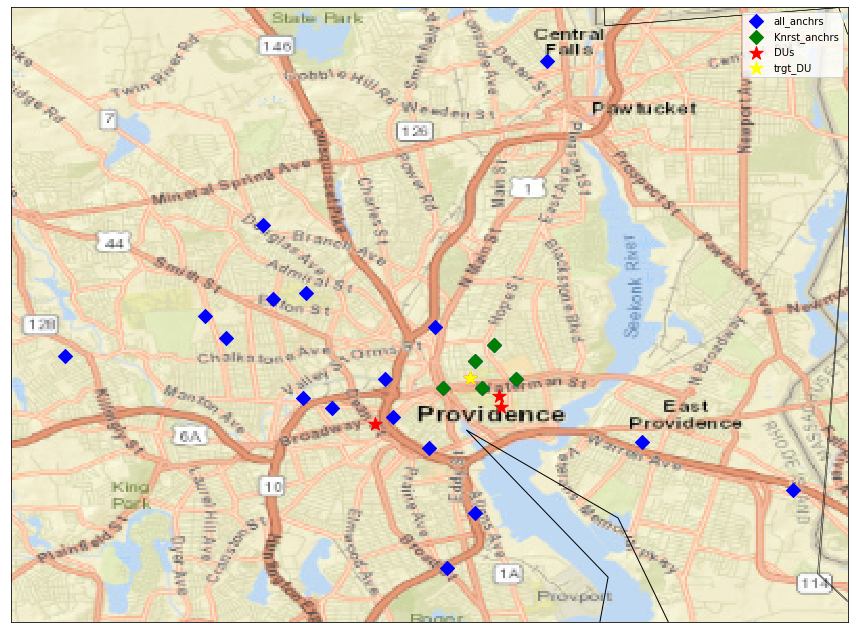

In [89]:
plot_nrst_nbr(anchor_table, DU_table, k_nearest_anchors, DU)

### Get 4G Anchor eNBs within d meters of a selected 5G DU

In [68]:
# 4G Anchor eNBs within d meters of selected 5G DU
d=1500
indices = anchor_table_tree.query_ball_point(cartesian(DU[0], DU[1]), d)
anchors_within_d_distance = anchor_table.iloc[indices].copy()
anchors_within_d_distance['Distance'] = anchors_within_d_distance.apply(lambda x: latlon_distance
                                                                        (x[['Latitude', 'Longitude']], DU), axis=1)
anchors_within_d_distance.sort_values(by=['Distance'])

,SITE,eNB,Latitude,Longitude,Distance
0,BROWN_ODAS01_RI,60509,41.827089,-71.402182,276.056721
1,BROWN_ODAS02_RI,60510,41.831961,-71.403545,336.395517
11,PROVIDENCE_CNTR_RI,60068,41.827085,-71.409368,468.762124
3,BROWN_UNIVERSITY,60170,41.828808,-71.395911,697.217171
2,BROWN_ODAS03_RI,60511,41.834909,-71.400052,747.064285
19,PROVIDENCE_W_RVR_RI,60229,41.838187,-71.410768,1153.534617
13,PROVIDENCE_DT_RELO_RI,60152,41.828727,-71.419867,1288.311489
21,PROV_LASALLE_SQ_RI,60191,41.821778,-71.418528,1424.414037


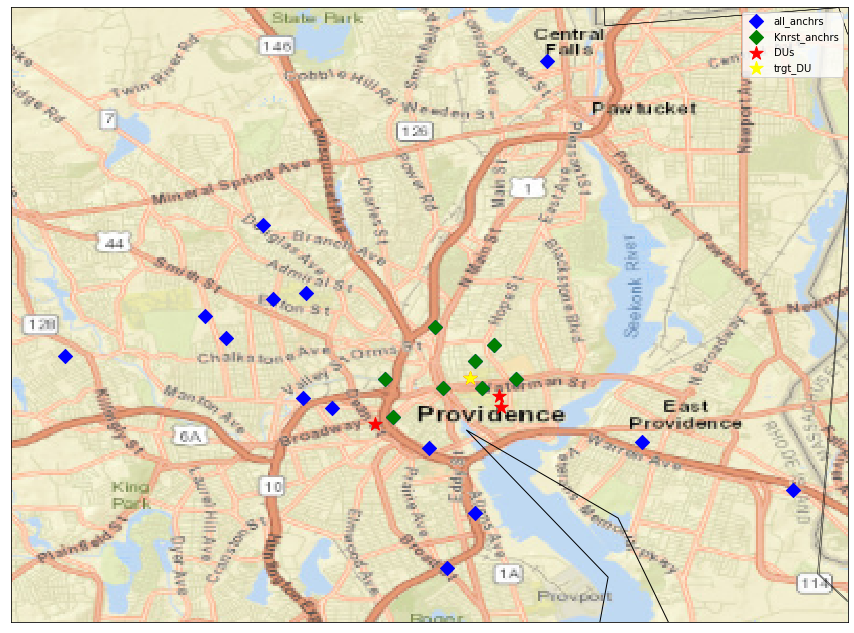

In [90]:
plot_nrst_nbr(anchor_table, DU_table, anchors_within_d_distance, DU)

In [5]:
# code to add distance to nbrs_within_d_distance 
def dist_add(nbrs_within_d_distance):
    if nbrs_within_d_distance.shape[0]!=0:    
        temp_tree = KDTree(
            nbrs_within_d_distance[['Latitude', 'Longitude']].values, distance_metric='Arc', 
            radius=RADIUS_EARTH_KM * 1000)
        k=nbrs_within_d_distance.shape[0]
        distances, indices = temp_tree.query(DU, k=k)
        k_nearest_nbrs = nbrs_within_d_distance.iloc[indices].copy()
        k_nearest_nbrs['Distance'] = distances
    return(k_nearest_nbrs)

In [88]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
def plot_nrst_nbr(target_table, source_table, selected_nbrs_table, target_loc):
    plt.figure(figsize=(15,15))
    bot_left_lat  =target_table[['Latitude']].values.min()-0.01
    bot_left_lon  =target_table[['Longitude']].values.min()-0.01
    top_right_lat =target_table[['Latitude']].values.max()+0.01
    top_right_lon = target_table[['Longitude']].values.max()+0.01
    map = Basemap(projection='cyl',llcrnrlon=bot_left_lon, llcrnrlat=bot_left_lat, urcrnrlon=top_right_lon, 
                  urcrnrlat=top_right_lat,resolution='i' )
    map.drawcoastlines()
    map.drawcountries()
    map.drawstates()
    map.drawrivers(color='blue')
    map.arcgisimage(service='World_Street_Map', verbose=False)
    ##########################################
    lons = target_table[['Longitude']].values
    lats = target_table[['Latitude']].values
    x, y = map(lons, lats)
    map.scatter(x, y, marker='D', s=100,color='blue', label='all_anchrs' )
    ##########################################
    lons = selected_nbrs_table[['Longitude']].values
    lats = selected_nbrs_table[['Latitude']].values
    x, y = map(lons, lats)
    map.scatter(x, y, marker='D', s=100,color='g', label='Knrst_anchrs')
    ##########################################
    lons = source_table[['Longitude']].values
    lats = source_table[['Latitude']].values
    x, y = map(lons, lats)
    map.scatter(x, y, marker='*', s=200 ,color='r', label='DUs')
    ##########################################
    lons = target_loc[1]
    lats = target_loc[0]
    x, y = map(lons, lats)
    map.scatter(x, y, marker='*', s=200, color='yellow', label='trgt_DU')

    plt.legend()


In [7]:
import math
def latlon_distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    # approximate radius of earth in m
    radius = 6371000
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [8]:
def cartesian(latitude, longitude, elevation = 0):
    # Convert to radians
    latitude = latitude * (math.pi / 180)
    longitude = longitude * (math.pi / 180)

    R = 6371000 # 6378137.0 + elevation  # relative to centre of the earth
    X = R * math.cos(latitude) * math.cos(longitude)
    Y = R * math.cos(latitude) * math.sin(longitude)
    Z = R * math.sin(latitude)
    return (X, Y, Z)

cartesian(*list((41.49008, -71.312796)))

(1529060.6767794264, -4520739.477097018, 4220726.125555106)

DU = PVD_COLH_088_RI 

1- Return K nearest neighbors to the DU above 
k=4

    k_nearest_anchors
        SITE	eNB	Latitude	Longitude	Distance
    0	BROWN_ODAS01_RI	60509	41.82709	-71.40218	276.05672
    1	BROWN_ODAS02_RI	60510	41.83196	-71.40355	336.39552
    11	PROVIDENCE_CNTR_RI	60068	41.82709	-71.40937	468.76212
    3	BROWN_UNIVERSITY	60170	41.82881	-71.39591	697.21717

    Actual Anchors:
    eNB	gNB	5G DU
    60068	600002	PVD_COLH_088_RI
    60170	600002	PVD_COLH_088_RI
    60506	600002	PVD_COLH_088_RI (missed)
    60510	600002	PVD_COLH_088_RI


DU = PVD_COLH_088_RI 

2- Return neighbors within 1500m  to the DU above   
d=1500

    anchors_within_d_distance
        SITE	eNB	Latitude	Longitude	Distance
    0	BROWN_ODAS01_RI	60509	41.82709	-71.40218	276.056721
    1	BROWN_ODAS02_RI	60510	41.83196	-71.40355	336.395517
    11	PROVIDENCE_CNTR_RI	60068	41.82709	-71.40937	468.762124
    3	BROWN_UNIVERSITY	60170	41.82881	-71.39591	697.217171
    2	BROWN_ODAS03_RI	60511	41.83491	-71.40005	747.064285
    19	PROVIDENCE_W_RVR_RI	60229	41.83819	-71.41077	1153.53462
    13	PROVIDENCE_DT_RELO_RI	60152	41.82873	-71.41987	1288.31149
    21	PROV_LASALLE_SQ_RI	60191	41.82178	-71.41853	1424.41404

    Actual Anchors:
    eNB	gNB	5G DU
    60068	600002	PVD_COLH_088_RI
    60170	600002	PVD_COLH_088_RI
    60506	600002	PVD_COLH_088_RI
    60510	600002	PVD_COLH_088_RI


In [9]:
'''from pysal.lib.cg import KDTree, RADIUS_EARTH_KM
#from scipy.spatial.kdtree import KDTree as EuclideanKDTree
# Initialize k-d tree
anchor_table_c=anchor_table.copy()
anchors_latlons = anchor_table_c[['Latitude', 'Longitude']].values
anchor_table_tree_pysal = KDTree(
    anchors_latlons, distance_metric='Arc', radius=RADIUS_EARTH_KM * 1000)'''

"from pysal.lib.cg import KDTree, RADIUS_EARTH_KM\n#from scipy.spatial.kdtree import KDTree as EuclideanKDTree\n# Initialize k-d tree\nanchor_table_c=anchor_table.copy()\nanchors_latlons = anchor_table_c[['Latitude', 'Longitude']].values\nanchor_table_tree_pysal = KDTree(\n    anchors_latlons, distance_metric='Arc', radius=RADIUS_EARTH_KM * 1000)"

In [10]:
'''# Get the k nearest 4G Anchor eNBs to selected 5G DU
DU=DU_table[['Latitude', 'Longitude']].values[0]
k=3
distances, indices = anchor_table_tree_pysal.query([DU], k=k)
k_nearest_anchors = anchor_table.iloc[indices.ravel()].copy()
k_nearest_anchors['Distance'] = distances.ravel()
k_nearest_anchors['Distance2'] = k_nearest_anchors.apply(lambda x: latlon_distance(x[['Latitude', 'Longitude']], DU), 
                                                          axis=1)
k_nearest_anchors'''

"# Get the k nearest 4G Anchor eNBs to selected 5G DU\nDU=DU_table[['Latitude', 'Longitude']].values[0]\nk=3\ndistances, indices = anchor_table_tree_pysal.query([DU], k=k)\nk_nearest_anchors = anchor_table.iloc[indices.ravel()].copy()\nk_nearest_anchors['Distance'] = distances.ravel()\nk_nearest_anchors['Distance2'] = k_nearest_anchors.apply(lambda x: latlon_distance(x[['Latitude', 'Longitude']], DU), \n                                                          axis=1)\nk_nearest_anchors"

In [11]:
'''from sklearn.neighbors import KDTree
anchor_table_tree_sk = KDTree(anchors_latlons)'''

'from sklearn.neighbors import KDTree\nanchor_table_tree_sk = KDTree(anchors_latlons)'

In [12]:
'''# Get the k nearest 4G Anchor eNBs to selected 5G DU
DU=DU_table[['Latitude', 'Longitude']].values[0]
k=6
distances, indices = anchor_table_tree_sk.query([DU], k=k)
k_nearest_anchors = anchor_table.iloc[indices.ravel()].copy()
k_nearest_anchors['Distance'] = distances.ravel()
k_nearest_anchors['Distance2'] = k_nearest_anchors.apply(lambda x: latlon_distance(x[['Latitude', 'Longitude']], DU), 
                                                          axis=1)
k_nearest_anchors'''

"# Get the k nearest 4G Anchor eNBs to selected 5G DU\nDU=DU_table[['Latitude', 'Longitude']].values[0]\nk=6\ndistances, indices = anchor_table_tree_sk.query([DU], k=k)\nk_nearest_anchors = anchor_table.iloc[indices.ravel()].copy()\nk_nearest_anchors['Distance'] = distances.ravel()\nk_nearest_anchors['Distance2'] = k_nearest_anchors.apply(lambda x: latlon_distance(x[['Latitude', 'Longitude']], DU), \n                                                          axis=1)\nk_nearest_anchors"